In [1]:
import hashlib
import io
import logging
import os
import random
import re

from lxml import etree
import PIL.Image
import tensorflow as tf

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

import coco_text
import matplotlib.pyplot as plt

In [2]:
data_dir = '/home/zbychuj/Desktop/models/object_detection/data/'
label_map_dict = label_map_util.get_label_map_dict(data_dir + 'cocotext_label_map.pbtxt')
ct = coco_text.COCO_Text(data_dir + 'COCO_Text.json')
image_dir = '/media/zbychuj/DATA/cocotext_images'

for img in ct.imgs.values():
    img['anns'] = []
    
for _, ann in ct.anns.items():
    ct.imgs[ann['image_id']]['anns'] += [ann]
    
for _, data in ct.imgs.items():
    data['has_legible_english_ann'] = False

    for ann in data['anns']:
        if ann['legibility'] == u'legible' and ann['language'] == u'english':
            data['has_legible_english_ann'] = True

loading annotations into memory...
0:00:02.814374
creating index...
index created!


In [4]:
imgs = ct.imgs.values()
random.shuffle(imgs)
imgs

[{'anns': [],
  u'file_name': u'COCO_train2014_000000321438.jpg',
  'has_legible_english_ann': False,
  u'height': 500,
  u'id': 321438,
  u'set': u'test',
  u'width': 332},
 {'anns': [],
  u'file_name': u'COCO_train2014_000000170803.jpg',
  'has_legible_english_ann': False,
  u'height': 480,
  u'id': 170803,
  u'set': u'val',
  u'width': 640},
 {'anns': [],
  u'file_name': u'COCO_train2014_000000127035.jpg',
  'has_legible_english_ann': False,
  u'height': 457,
  u'id': 127035,
  u'set': u'train',
  u'width': 640},
 {'anns': [{u'area': 1195.359450435956,
    u'bbox': [355.6356736242884,
     235.74683544303795,
     65.57874762808353,
     18.227848101265867],
    u'class': u'machine printed',
    u'id': 1150910,
    u'image_id': 497617,
    u'language': u'na',
    u'legibility': u'illegible',
    u'polygon': [355.6356736242884,
     235.74683544303795,
     421.21442125237195,
     235.74683544303795,
     421.21442125237195,
     253.97468354430382,
     355.6356736242884,
     253.

In [5]:
num_img_with_anns = 0
num_img_without_anns = 0
img_sizes = []
anns_sizes = []

for _, data in ct.imgs.items():
    
    if data['set'] not in ['test']:
        continue
    
    if data['has_legible_english_ann']:
        num_img_with_anns += 1
    else:
        num_img_without_anns += 1

    img_sizes += [(data['height'], data['width'])]
    
    for obj in data['anns']:
        if obj['legibility'] == u'legible' or obj['language'] == u'english':
            anns_sizes += [(obj['bbox'][2], obj['bbox'][3])]
        
print num_img_with_anns
print num_img_without_anns

0
10000


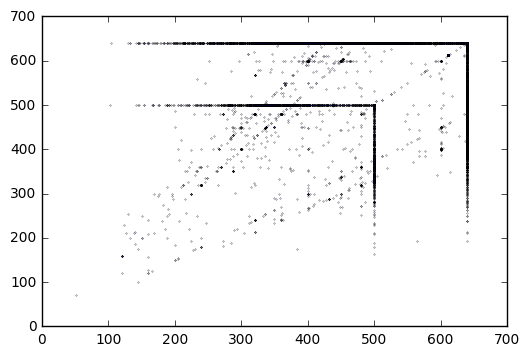

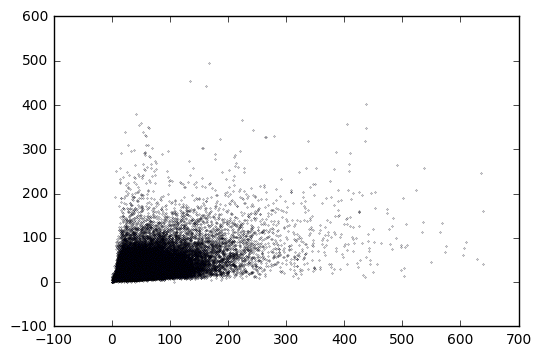

In [60]:
plt.figure()
plt.scatter(*zip(*img_sizes), marker='.', s=0.2)
plt.show()

plt.figure()
plt.scatter(*zip(*anns_sizes), marker='.', s=0.2)
plt.show()

In [57]:
anns_sizes = [(h,w) for h,w in anns_sizes if h>0 and w>0]
ratios = [int(float(h)/float(w)) for h,w in anns_sizes]
inv_ratios = [int(float(w)/float(h)) for h,w in anns_sizes]

print [[x,ratios.count(x)] for x in range(100)]
print ''
print [[x,inv_ratios.count(x)] for x in range(100)]


[[0, 17958], [1, 36703], [2, 23297], [3, 10902], [4, 4783], [5, 2100], [6, 952], [7, 476], [8, 267], [9, 156], [10, 89], [11, 67], [12, 37], [13, 24], [14, 21], [15, 11], [16, 8], [17, 11], [18, 2], [19, 7], [20, 2], [21, 1], [22, 2], [23, 1], [24, 0], [25, 1], [26, 1], [27, 0], [28, 0], [29, 0], [30, 0], [31, 0], [32, 1], [33, 1], [34, 1], [35, 1], [36, 1], [37, 1], [38, 1], [39, 0], [40, 0], [41, 0], [42, 0], [43, 0], [44, 0], [45, 0], [46, 0], [47, 0], [48, 0], [49, 0], [50, 1], [51, 0], [52, 0], [53, 0], [54, 0], [55, 0], [56, 0], [57, 1], [58, 0], [59, 0], [60, 0], [61, 0], [62, 0], [63, 0], [64, 0], [65, 0], [66, 0], [67, 0], [68, 0], [69, 0], [70, 0], [71, 0], [72, 0], [73, 0], [74, 0], [75, 0], [76, 0], [77, 1], [78, 0], [79, 0], [80, 0], [81, 1], [82, 0], [83, 0], [84, 0], [85, 0], [86, 0], [87, 0], [88, 0], [89, 0], [90, 0], [91, 0], [92, 0], [93, 0], [94, 0], [95, 1], [96, 0], [97, 0], [98, 0], [99, 0]]

[[0, 79768], [1, 15060], [2, 1978], [3, 569], [4, 262], [5, 122], [6, 4

In [8]:
def create_tf_record(output_filename,
                     datasets):

    if os.path.exists(output_filename):
        os.remove(output_filename)
    writer = tf.python_io.TFRecordWriter(output_filename)
    
    datas = ct.imgs.values()
    new_datas = []
    for data in datas:
        if data['has_legible_english_ann']:
            new_datas += [data, data, data]
        else:
            new_datas += [data]
    random.shuffle(new_datas)
    
    for data in new_datas:
    
        if data['set'] not in datasets:
            continue
        
        #if not data['has_legible_english_ann']:
        #    continue
            
        img_path = os.path.join(image_dir, data['file_name'])
        with tf.gfile.GFile(img_path) as fid:
            encoded_jpg = fid.read()
            encoded_jpg_io = io.BytesIO(encoded_jpg)
            image = PIL.Image.open(encoded_jpg_io)
        if image.format != 'JPEG':
            raise ValueError('Image format not JPEG')

        width = int(data['width'])
        height = int(data['height'])

        xmin = []
        ymin = []
        xmax = []
        ymax = []
        classes = []
        classes_text = []
        truncated = []
        poses = []
        for obj in data['anns']:
            if obj['legibility'] != u'legible' or obj['language'] != u'english':
                continue
            
            # TODO(zbigniew): clean '\n' ' ' characters from words
            text = obj['utf8_string']
            text = text.replace(u'\xa1', chr(1))
            text = text.replace(u'\xa2', chr(2))
            text = text.replace(u'\xa3', chr(3))
            text = text.replace(u'\xa9', chr(4))
            text = text.replace(u'\xb0', chr(5))
            text = text.replace(u'\xc9', chr(6))
            text = text.replace(u'\u2022', chr(7))
            text = text.replace(u'\u20ac', chr(8))
            text = text.replace(u'\u2605', chr(9))
            text = text.lower()
            text = text[:15]
            text += chr(10)
            text = text.ljust(16, chr(0))
            classes_text.append(str(text))
            
            classes.append(1)
            
            # [left, top, width, height],
            xmin.append(float(obj['bbox'][0]) / width)
            ymin.append(float(obj['bbox'][1]) / height)
            xmax.append(float(obj['bbox'][0] + obj['bbox'][2]) / width)
            ymax.append(float(obj['bbox'][1] + obj['bbox'][3]) / height)


        tf_example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': dataset_util.int64_feature(height),
          'image/width': dataset_util.int64_feature(width),
          'image/filename': dataset_util.bytes_feature(str(data['file_name'])),
          'image/source_id': dataset_util.bytes_feature(str(data['file_name'])),
          'image/encoded': dataset_util.bytes_feature(encoded_jpg),
          'image/format': dataset_util.bytes_feature('jpeg'),
          'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
          'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
          'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
          'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
          'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
          'image/object/class/label': dataset_util.int64_list_feature(classes),
        }))
        writer.write(tf_example.SerializeToString())
    
    writer.close()

In [9]:
train_output_path = os.path.join(data_dir, 'cocotext_train.record')
val_output_path = os.path.join(data_dir, 'cocotext_val.record')
trainval_output_path = os.path.join(data_dir, 'cocotext_trainval.record')
test_output_path = os.path.join(data_dir, 'cocotext_test.record')

#create_tf_record(train_output_path, ['train'])
#create_tf_record(val_output_path, ['val'])
#create_tf_record(trainval_output_path, ['train', 'val'])
create_tf_record(test_output_path, ['test'])


In [ ]:
ymin, xmin, ymax, xmax